In [1]:
import keras
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
from itertools import chain
from keras.models import Model
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.manifold import TSNE
from gensim.models import FastText
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split 
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import CountVectorizer
from keras.layers import Input, Embedding, LSTM, Dense, Bidirectional

import warnings
warnings.filterwarnings("ignore")

# Initializing tqdm for pandas
tqdm.pandas()

Using TensorFlow backend.


In [2]:
np.random.seed(0)

In [3]:
citations_features = pd.read_parquet('./citations_features.parquet/', engine='pyarrow')
dataset = pd.read_csv('dataset.csv')

In [4]:
# Merging the citation and their corresponding features which have been extracted
dataset_with_features = pd.merge(
    dataset, citations_features, how='inner', left_on=['id','citation'], right_on = ['id','citation']
)
dataset_with_features.drop('page_title_y', axis=1, inplace=True)
dataset_with_features.drop('Unnamed: 0', axis=1, inplace=True)

In [5]:
# Only consider unique citations so that the dataset is more varied
dataset_with_features  = dataset_with_features.set_index(['id', 'citation'])
dataset_with_features = dataset_with_features[~dataset_with_features.index.duplicated(keep='first')]
dataset_with_features = dataset_with_features.reset_index()

## Get auxiliary features 

1. `ref_index`
2. `total_words`
3. `sections`
4. `tags`
5. `type_of_citation`

### Taking the unique `sections` and one hot encoding it to get a vector

In [6]:
# Only processing auxiliary features which are going to be used in the neural network
auxiliary_features = dataset_with_features[
    ['sections', 'citation_type', 'citation', 'id', 'ref_index',
     'total_words', 'neighboring_tags', 'scientific_or_not']]

In [7]:
auxiliary_features['sections'] = auxiliary_features['sections'].astype(str)
auxiliary_features['sections'] = auxiliary_features['sections'].apply(lambda x: x.split(', '))

In [8]:
section_counts = pd.Series(Counter(chain.from_iterable(x for x in auxiliary_features.sections)))
largest_sections = section_counts.nlargest(150)

In [9]:
# Change section to `OTHERS` if occurence of the section is not in the 150 largest sections
auxiliary_features['sections'] = auxiliary_features['sections'].progress_apply(
    lambda x: list(set(['Others' if i not in largest_sections else i for i in x]))
)

100%|██████████| 1906419/1906419 [00:06<00:00, 293689.78it/s]


In [10]:
section_dummies = pd.get_dummies(auxiliary_features.sections.apply(pd.Series).stack())

In [11]:
auxiliary_features = auxiliary_features.join(section_dummies.sum(level=0))

In [12]:
auxiliary_features.drop('sections', axis=1, inplace=True)
auxiliary_features.head()

,citation_type,citation,id,ref_index,total_words,neighboring_tags,scientific_or_not,20th century,Activity,Adverse effects,...,Treatment,Treatments,Types,Usage,Use,Uses,Work,Works,[[Actinobacteria]],nan
0,cite journal,{{cite journal | author= Kenneth Cornetta | au...,1831220,946,1649,"[IN, DT, JJ, NN, TO, VB, IN, JJ, NN, :, NNS, I...",True,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,cite journal,{{cite journal|last=Sorgi|first=FL|author2=Bha...,1831220,1034,1649,"[CD, JJ, NN, CD, NN, CC, JJ, NN, ., VBG, JJ, N...",True,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,cite journal,{{cite journal|last=Walker|first=WS|author2=Re...,1831220,1194,1649,"[JJ, NNS, VBG, NN, CC, VBD, CC, JJ, NNS, ., NN...",True,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,cite journal,{{cite journal|last=Campbell|first=FW|author2=...,1831220,1268,1649,"[NNP, NN, CD, NN, CD, NNS, CD, NN, CD, NN, CD,...",True,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,cite journal,{{cite journal|last=Welsby|first=IJ|author2=Ne...,1831220,1360,1649,"[CD, '', NN, NN, NNP, CD, NN, NN, '', JJ, CD, ...",True,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Taking the `type of citations` and one hot encoding it to get a vector

In [13]:
# Get one hot encoding of citation_type column
citation_type_encoding = pd.get_dummies(auxiliary_features['citation_type'])

In [14]:
# Drop column citation_type as it is now encoded and join it
auxiliary_features = auxiliary_features.drop('citation_type', axis = 1)

In [15]:
# Concat columns of the dummies along the axis with the matching index
auxiliary_features = pd.concat([auxiliary_features, citation_type_encoding], axis=1)
auxiliary_features.head()

,citation,id,ref_index,total_words,neighboring_tags,scientific_or_not,20th century,Activity,Adverse effects,Aftermath,...,cite journal,cite map,cite news,cite newsgroup,cite report,cite speech,cite techreport,cite thesis,cite web,harvnb
0,{{cite journal | author= Kenneth Cornetta | au...,1831220,946,1649,"[IN, DT, JJ, NN, TO, VB, IN, JJ, NN, :, NNS, I...",True,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,{{cite journal|last=Sorgi|first=FL|author2=Bha...,1831220,1034,1649,"[CD, JJ, NN, CD, NN, CC, JJ, NN, ., VBG, JJ, N...",True,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,{{cite journal|last=Walker|first=WS|author2=Re...,1831220,1194,1649,"[JJ, NNS, VBG, NN, CC, VBD, CC, JJ, NNS, ., NN...",True,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,{{cite journal|last=Campbell|first=FW|author2=...,1831220,1268,1649,"[NNP, NN, CD, NN, CD, NNS, CD, NN, CD, NN, CD,...",True,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,{{cite journal|last=Welsby|first=IJ|author2=Ne...,1831220,1360,1649,"[CD, '', NN, NN, NNP, CD, NN, NN, '', JJ, CD, ...",True,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


As we can see for the feature `total_number_of_words`, the mean and median **(since it is more robust in nature!)** are pretty high for articles which are non scientific than the articles which are scientific in nature.

In [16]:
print('Total mean length of scientific articles: {}'.format(
    auxiliary_features[auxiliary_features['scientific_or_not'] == True]['total_words'].mean()))
print('Total median length of scientific articles: {}'.format(
    auxiliary_features[auxiliary_features['scientific_or_not'] == True]['total_words'].median()))

Total mean length of scientific articles: 6880.838957288607
Total median length of scientific articles: 3089.0


In [17]:
print('Total mean length of NON-scientific articles: {}'.format(
    auxiliary_features[auxiliary_features['scientific_or_not'] == False]['total_words'].mean()))
print('Total median length of NON-scientific articles: {}'.format(
    auxiliary_features[auxiliary_features['scientific_or_not'] == False]['total_words'].median()))

Total mean length of NON-scientific articles: 11202.782249006195
Total median length of NON-scientific articles: 4569.0


### Taking the `neighboring_tags` and making an encoder dictionary for it

To have more info about how what tag mean what: https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html

In [18]:
citation_tag_features = dataset_with_features[['id', 'citation', 'neighboring_tags']]

In [19]:
citation_tag_features['neighboring_tags'].iloc[0]

array(['IN', 'DT', 'JJ', 'NN', 'TO', 'VB', 'IN', 'JJ', 'NN', ':', 'NNS',
       'IN', 'JJ', 'NN', 'JJ', 'JJ', 'NNP', 'IN', 'NNP', 'NNP', 'NN',
       'CD', 'NN', 'CD', 'NN', 'NN', 'CD', 'NN', ':', 'JJ', 'JJ', 'CD',
       'JJ', 'NN', 'CD', 'NN', 'NN', 'NN', 'NNP', 'CD'], dtype=object)

In [20]:
# Get the count for each POS tag so that we have an estimation as to how many are there
tag_counts = pd.Series(Counter(chain.from_iterable(x for x in citation_tag_features.neighboring_tags)))

In [21]:
# Considering the 10 smallest tags and checking which one does not have resemblance
tag_counts.nsmallest(10) 

LS         1
``       398
UH      2576
WP$     2741
SYM     3352
PDT     4764
$      11931
RBS    15975
EX     19417
RBR    28835
dtype: int64

We are going to replace `LS`, `the 2 backquotes` and the `the dollar symbol` since they do not have too much use case and do not give too much information about the context of the neighboring citation text.

In [22]:
OTHER_TAGS = ['LS', '``', '$']
citation_tag_features['neighboring_tags'] = citation_tag_features['neighboring_tags'].progress_apply(
    lambda x: [i if i not in OTHER_TAGS else 'Others' for i in x]
)

100%|██████████| 1906419/1906419 [00:14<00:00, 131585.68it/s]


Now, we can use the `count vectorizer` to represent the `POS tags` as a vector where each element of the vector represents the count of that tag in that particular citation.

In [23]:
cv = CountVectorizer() # Instantiate the vectorizer

In [24]:
citation_tag_features['neighboring_tags'] = citation_tag_features['neighboring_tags'].progress_apply(
    lambda x: " ".join(x))

100%|██████████| 1906419/1906419 [00:02<00:00, 642652.34it/s]


In [25]:
transformed_neighboring_tags = cv.fit_transform(citation_tag_features['neighboring_tags'])
transformed_neighboring_tags = pd.DataFrame(transformed_neighboring_tags.toarray(), columns=cv.get_feature_names())

In [26]:
citation_tag_features = pd.concat([citation_tag_features, transformed_neighboring_tags], axis=1)

In [27]:
citation_tag_features.drop('neighboring_tags', axis=1, inplace=True)
citation_tag_features.head()

,id,citation,cc,cd,dt,ex,fw,in,jj,jjr,...,vb,vbd,vbg,vbn,vbp,vbz,wdt,wikicode,wp,wrb
0,1831220,{{cite journal | author= Kenneth Cornetta | au...,0,6,1,0,0,4,8,0,...,1,0,0,0,0,0,0,0,0,0
1,1831220,{{cite journal|last=Sorgi|first=FL|author2=Bha...,1,5,0,0,0,0,6,0,...,0,1,1,0,1,0,0,0,0,0
2,1831220,{{cite journal|last=Walker|first=WS|author2=Re...,2,2,0,0,0,2,5,0,...,1,1,1,0,0,0,0,0,0,0
3,1831220,{{cite journal|last=Campbell|first=FW|author2=...,0,8,1,0,0,3,3,0,...,0,0,0,0,0,0,0,0,0,0
4,1831220,{{cite journal|last=Welsby|first=IJ|author2=Ne...,0,4,0,0,0,3,6,0,...,0,0,0,0,0,0,0,0,0,0


## Features for the LSTM - more time sequence related

### Citation's original text features

In [28]:
# Create a separate dataframe for preprocessing citation text
citation_text_features = dataset_with_features[['id', 'citation', 'scientific_or_not']]

In [29]:
# Convert the citation into a list by breaking it down into characters
citation_text_features['characters'] = citation_text_features['citation'].progress_apply(lambda x: list(x))

100%|██████████| 1906419/1906419 [00:30<00:00, 62348.30it/s] 


In [30]:
# Get the character counts for each unique character
char_counts = pd.Series(Counter(chain.from_iterable(x for x in citation_text_features.characters)))
char_counts.index

Index(['{', 'c', 'i', 't', 'e', ' ', 'j', 'o', 'u', 'r', 'n', 'a', 'l', '|',
       'h', '=', 'K', 'C', '2', 'W', '.', 'F', 'A', 'd', 's', 'P', 'm', 'f',
       'v', 'p', 'y', 'b', '-', 'g', ':', 'J', 'V', 'M', '1', '9', '8', '3',
       '7', '\', '0', '4', '/', 'w', '6', '(', ')', '}', 'S', 'L', 'B', ',',
       'H', 'G', 'k', 'R', 'D', 'I', '5', 'E', 'N', 'z', 'T', 'x', 'O', '&',
       'Z', '?', 'Y', 'q', 'U', 'Q', '_', 'X', ';', '[', ']', '+', '#', '%',
       '!', ''', '"', '~', '<', '>', '*', '`', '^', '@', '$'],
      dtype='object')

In [31]:
print('The max length of the longest citation in terms of characters is: {}'.format(
    max(citation_text_features.characters.apply(lambda x: len(x)))))

print('The mean length of the longest citation in terms of characters is: {}'.format(
    citation_text_features.characters.apply(lambda x: len(x)).mean()))

print('The median length of the longest citation in terms of characters is: {}'.format(
    citation_text_features.characters.apply(lambda x: len(x)).median()))

The max length of the longest citation in terms of characters is: 34353
The mean length of the longest citation in terms of characters is: 301.7196272173116
The median length of the longest citation in terms of characters is: 282.0


In [32]:
# Make a dictionary for creating a mapping between the char and the corresponding index
char2ind = {char: i for i, char in enumerate(char_counts.index)}
ind2char = {i: char for i, char in enumerate(char_counts.index)}

In [33]:
# Map each character into the citation to its corresponding index and store it in a list
X_char = []
for citation in citation_text_features.citation:
    citation_chars = []
    for character in citation:
        citation_chars.append(char2ind[character])
        
    X_char.append(citation_chars)

In [34]:
# Since the median length of the citation is 300, we have padded it till 400 just to play it safe
with tf.device('/gpu:0'):
    X_char = pad_sequences(X_char, maxlen=400)

In [35]:
# Append the citation character list with their corresponding lists for making a dataset
# for getting the character embeddings
data = []
for i in tqdm(range(len(X_char))):
    data.append((X_char[i], int(citation_text_features.iloc[i]['scientific_or_not'])))

100%|██████████| 1906419/1906419 [06:54<00:00, 4603.57it/s]


In [36]:
# Separate out the training data and labels for further verification use
training_data = [i[0] for i in data]
training_labels = [i[1] for i in data]

In [37]:
def citation_embedding_model():
    """
    Citation embedding generator model where the dimension of the embedding is 50.
    """
    main_input = Input(shape=(400, ), name='characters')
    # input dim is basically the vocab size
    emb = Embedding(input_dim=95, output_dim = 300, name='citation_embedding')(main_input)
    rnn = Bidirectional(LSTM(20))
    x = rnn(emb)
    de = Dense(1, activation='sigmoid')(x)
    model = Model(inputs = main_input, outputs = de)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [38]:
# Instantiate the model and generate the summary
model = citation_embedding_model()
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
characters (InputLayer)      (None, 400)               0         
_________________________________________________________________
citation_embedding (Embeddin (None, 400, 300)          28500     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 40)                51360     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 41        
Total params: 79,901
Trainable params: 79,901
Non-trainable params: 0
_________________________________________________________________


In [39]:
def generator(features, labels, batch_size):
    """
    Generator to create batches of data so that processing is easy.
    
    :param: features: the features of the model.
    :param: labels: the labels of the model.
    :param: batch_size: the size of the batch
    """
    # Create empty arrays to contain batch of features and labels
    batch_features = np.zeros((batch_size, 400))
    batch_labels = np.zeros((batch_size, 1))
    while True:
        for i in range(batch_size):
            # choose random index in features
            index = np.random.choice(len(features), 1)[0]
            batch_features[i] = features[index]
            batch_labels[i] = labels[index]
        yield batch_features, batch_labels

In [40]:
# Run the model with the data being generated by the generator with a batch size of 64
# and number of epochs to be set to 15
hist = model.fit_generator(generator(training_data, training_labels, 64), samples_per_epoch=30, nb_epoch=15)

Instructions for updating:
Use tf.cast instead.
Epoch 1/15
30/30 [==============================] - 15s 516ms/step - loss: 0.6459 - acc: 0.6177
Epoch 2/15
30/30 [==============================] - 14s 466ms/step - loss: 0.5031 - acc: 0.7901
Epoch 3/15
30/30 [==============================] - 14s 467ms/step - loss: 0.4059 - acc: 0.8161
Epoch 4/15
30/30 [==============================] - 14s 460ms/step - loss: 0.4090 - acc: 0.8177
Epoch 5/15
30/30 [==============================] - 14s 468ms/step - loss: 0.4009 - acc: 0.8203
Epoch 6/15
30/30 [==============================] - 14s 456ms/step - loss: 0.3891 - acc: 0.8318
Epoch 7/15
30/30 [==============================] - 14s 475ms/step - loss: 0.3693 - acc: 0.8370
Epoch 8/15
30/30 [==============================] - 14s 461ms/step - loss: 0.3490 - acc: 0.8474
Epoch 9/15
30/30 [==============================] - 14s 475ms/step - loss: 0.3350 - acc: 0.8474
Epoch 10/15
30/30 [==============================] - 14s 456ms/step - loss: 0.3019 - acc

In [41]:
# Save the model so that we can retrieve it later
model.save('./embedding_model.h5')

In [42]:
# Get the `citation_embedding` layer and get the weights for each character
citation_layer = model.get_layer('citation_embedding')
citation_weights = citation_layer.get_weights()[0]
citation_weights.shape

(95, 300)

In [43]:
citation_weights[0][:100]

array([-2.84727220e-03,  3.33610587e-02, -3.15780006e-03, -5.07337563e-02,
        1.44584533e-02, -9.39751230e-03, -2.81345507e-04,  2.87252176e-03,
       -2.98749246e-02, -1.71153788e-02,  7.22671440e-03, -9.94444359e-03,
        4.58758092e-03,  6.33232296e-02,  1.83253326e-02,  6.00498356e-02,
        1.45667745e-02, -2.56420542e-02,  2.58745961e-02,  3.26462425e-02,
        2.43279207e-02, -1.20067047e-02, -2.31037401e-02, -5.45615628e-02,
        2.86023654e-02,  7.26621249e-04, -8.55346117e-03,  4.64758724e-02,
        3.64563800e-02, -1.80851761e-02,  2.66167298e-02, -1.79941487e-02,
        2.20189672e-02,  2.33063772e-02, -7.60253938e-03, -1.50349515e-05,
       -4.74174917e-02, -3.52014750e-02, -4.95599844e-02, -1.88043732e-02,
        3.12287337e-03,  1.33375637e-02,  1.33376643e-02, -1.73049532e-02,
        2.85914652e-02,  1.16233551e-03,  5.64414486e-02,  7.38445437e-04,
       -4.04441059e-02,  2.54274555e-03, -4.58883904e-02, -7.29537606e-02,
        3.80322263e-02,  

In [44]:
# Map the embedding of each character to the character in each corresponding citation and aggregate (sum)
citation_text_features['embedding'] = citation_text_features['characters'].progress_apply(
    lambda x: sum([citation_weights[char2ind[c]] for c in x])
)

100%|██████████| 1906419/1906419 [10:20<00:00, 3069.94it/s]


In [45]:
# Normalize the citation embeddings so that we can check for their similarity later
citation_text_features['embedding'] = citation_text_features['embedding'].progress_apply(
    lambda x: x/ np.linalg.norm(x, axis=0).reshape((-1, 1))
)

100%|██████████| 1906419/1906419 [00:30<00:00, 62677.95it/s]


In [51]:
# Make the sum of the embedding to be summed up to 1
np.sum(np.square(citation_text_features['embedding'].iloc[0]))

0.9999999

### Similarity Graph for citation text embeddings

In [251]:
# Just considering 20 since otherwise it will be computationally extensive
citation_text_and_embeddings = citation_text_features[['citation', 'embedding']][:500]

In [252]:
citation_text_and_embeddings['embedding'] = citation_text_and_embeddings['embedding'].progress_apply(
    lambda x: x[0].tolist()
)

100%|██████████| 500/500 [00:00<00:00, 29612.43it/s]


In [255]:
def tsne_embedding_plot():
    labels = []
    tokens = []

    for index, row in citation_text_and_embeddings.iterrows():
        tokens.append(row['embedding'])
        labels.append(str(index))
    
    # Perplexity takes into account the global and local features
    # We are using dimensionality reduciton for 2 features and taking 2500 iterations into account
    tsne_model = TSNE(perplexity=40, n_components=2, n_iter=2500, random_state=0)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(15, 15)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i], xy=(x[i], y[i]), xytext=(5, 2),
                     textcoords='offset points', ha='right', va='bottom')
    plt.show()

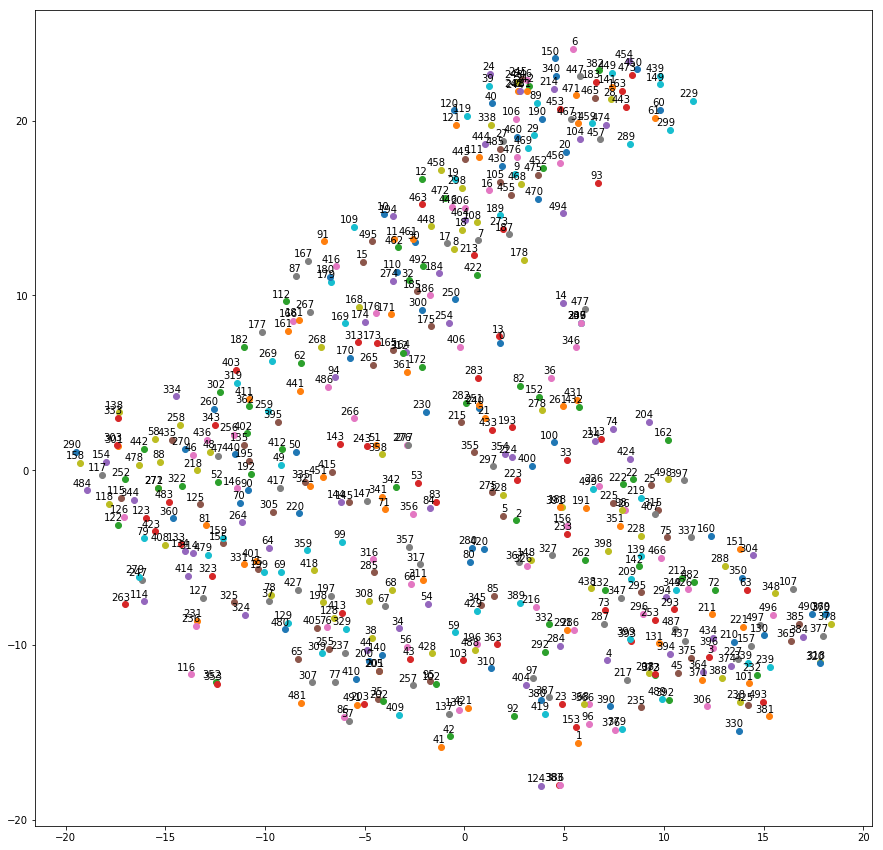

In [256]:
tsne_embedding_plot()

In [276]:
# an example of citation embeddings which is close to each other
citation_text_and_embeddings[citation_text_and_embeddings.index.isin([14, 477])] # (51, 243), (0, 13)

,citation,embedding
14,"{{cite journal | vauthors = Sorgi FL, Bhattacharya S, Huang L | title = Protamine sulfate enhances lipid-mediated gene transfer | journal = Gene Therapy | volume = 4 | issue = 9 | pages = 961\u201...","[-0.019867928698658943, -0.012315832078456879, 0.013255342841148376, 0.009797554463148117, -0.005100628826767206, -0.025957971811294556, 0.029690545052289963, -0.013163143768906593, 0.036435443907..."
477,"{{cite journal | title = Nomenclature for organic chemical transformations | author = Jones, R.A.Y. Bunnett, J.F. | journal = [[Pure Appl. Chem.]] | year = 1989 | volume = 61 | pages = 725\u201376...","[-0.007883568294346333, -0.014783266931772232, 0.016247959807515144, 0.006468991748988628, -0.030502483248710632, -0.007374242413789034, 0.027502497658133507, -0.01046613696962595, 0.0410450510680..."


In [281]:
# an example of citation embeddings which is NOT close to each other and are different
citation_text_and_embeddings[citation_text_and_embeddings.index.isin([6, 124])] # (6, 42)

,citation,embedding
6,{{cite journal | vauthors = Balhorn R | title = The protamine family of sperm nuclear proteins | journal = Genome Biology | volume = 8 | issue = 9 | pages = 227 | year = 2007 | pmid = 17903313 | p...,"[0.012881414964795113, -0.0015141917392611504, 0.03571730852127075, 0.01204552873969078, -0.023526238277554512, 0.004245442803949118, 0.014037451706826687, -0.0037081409245729446, 0.01420738827437..."
124,{{Cite book|title=\u9e64\u5c97\u5e02\u5fd7 History of Hegang |author=\u300a\u9e64\u5c97\u5e02\u5730\u65b9\u5fd7\u300b\u7f16\u7e82\u59d4\u5458\u4f1a\u529e\u516c\u5ba4 |year=1990 |publisher=\u9ed1\u...,"[-0.01741640456020832, -0.05237920209765434, -0.05126625671982765, -0.08922778069972992, -0.033835846930742264, -0.004329919349402189, 0.006279471796005964, 0.0028078556060791016, -0.0151479402557..."


### FastText embeddings for neighboring words

In [52]:
# Load the pretrained embedding model on wikipedia
model = FastText.load_fasttext_format('/dlabdata1/harshdee/wiki.en.bin')

In [53]:
# Create a separate dataframe for preprocessing citation words
citation_word_features = dataset_with_features[['id', 'citation', 'neighboring_words', 'scientific_or_not']]

In [54]:
citation_word_features['neighboring_words'] = citation_word_features['neighboring_words'].progress_apply(
    lambda x: [i.lower() for i in x]
)

100%|██████████| 1906419/1906419 [00:26<00:00, 71955.63it/s] 


In [55]:
word_counts = pd.Series(Counter(chain.from_iterable(x for x in citation_word_features.neighboring_words)))

In [56]:
threshold = 4

x = len(word_counts)
y = len(word_counts[word_counts <= threshold])
print('Total words: {}\nTotal number of words whose occurence is less than 20: {}\nDifference: {}'.format(x, y, x-y))
words_less_than_threshold = word_counts[word_counts <= threshold]

Total words: 5456540
Total number of words whose occurence is less than 20: 5018572
Difference: 437968


In [57]:
citation_word_features['neighboring_words'] = citation_word_features['neighboring_words'].progress_apply(
    lambda x: [i if i not in words_less_than_threshold else '<UNK>' for i in x]
)

100%|██████████| 1906419/1906419 [01:49<00:00, 17422.83it/s]


In [58]:
words = pd.Series(Counter(chain.from_iterable(x for x in citation_word_features.neighboring_words))).index

In [59]:
word2ind = {w: i for i, w in enumerate(words)}
ind2words = {i: w for i, w in enumerate(words)}

In [60]:
word_embedding_matrix = np.zeros((len(word2ind), 300))

In [61]:
for w in tqdm(word2ind):
    index = word2ind[w]
    word_embedding_matrix[index] = model.wv[w]

100%|██████████| 437969/437969 [00:31<00:00, 13972.50it/s]


In [62]:
citation_word_features['words_embedding'] = citation_word_features['neighboring_words'].progress_apply(
    lambda x: sum([word_embedding_matrix[word2ind[w]] for w in x])
)

100%|██████████| 1906419/1906419 [01:59<00:00, 16018.67it/s]


Now we have the `citation_text_features` and `citation_tag_features`, so we can join them together to form `time_sequence_features` which would be fed later into the LSTM..

In [63]:
time_sequence_features = pd.merge(
    citation_tag_features, citation_word_features,
    left_on=['id', 'citation'], right_on=['id', 'citation'], how='inner')

In [64]:
print('Total number of samples in time features are: {}'.format(len(time_sequence_features)))

Total number of samples in time features are: 1906419


In [65]:
time_sequence_features.columns

Index(['id', 'citation', 'cc', 'cd', 'dt', 'ex', 'fw', 'in', 'jj', 'jjr',
       'jjs', 'md', 'nn', 'nnp', 'nnps', 'nns', 'others', 'pdt', 'pos', 'prp',
       'rb', 'rbr', 'rbs', 'rp', 'sym', 'to', 'uh', 'vb', 'vbd', 'vbg', 'vbn',
       'vbp', 'vbz', 'wdt', 'wikicode', 'wp', 'wrb', 'neighboring_words',
       'scientific_or_not', 'words_embedding'],
      dtype='object')

In [66]:
time_sequence_features.drop(['neighboring_words'], axis=1, inplace=True)

In [67]:
time_sequence_features.head()

,id,citation,cc,cd,dt,ex,fw,in,jj,jjr,...,vbg,vbn,vbp,vbz,wdt,wikicode,wp,wrb,scientific_or_not,words_embedding
0,1831220,{{cite journal | author= Kenneth Cornetta | au...,0,6,1,0,0,4,8,0,...,0,0,0,0,0,0,0,0,True,"[2.2172083500772715, 1.8652248345315456, -4.12..."
1,1831220,{{cite journal|last=Sorgi|first=FL|author2=Bha...,1,5,0,0,0,0,6,0,...,1,0,1,0,0,0,0,0,True,"[1.8394884951412678, 3.045541481114924, -7.576..."
2,1831220,{{cite journal|last=Walker|first=WS|author2=Re...,2,2,0,0,0,2,5,0,...,1,0,0,0,0,0,0,0,True,"[1.2257937546819448, 3.9170858301222324, -4.93..."
3,1831220,{{cite journal|last=Campbell|first=FW|author2=...,0,8,1,0,0,3,3,0,...,0,0,0,0,0,0,0,0,True,"[1.7118084817193449, 2.515659366734326, -0.639..."
4,1831220,{{cite journal|last=Welsby|first=IJ|author2=Ne...,0,4,0,0,0,3,6,0,...,0,0,0,0,0,0,0,0,True,"[-0.34577748365700245, 3.1046539759263396, -2...."


In [71]:
auxiliary_features = pd.merge(
    auxiliary_features, citation_text_features,
    left_on=['id', 'citation_text'], right_on=['id', 'citation'], how='inner')

In [72]:
auxiliary_features.drop(['scientific_or_not_x', 'neighboring_tags', 'characters', 'citation_y'], axis=1, inplace=True)
auxiliary_features.rename(columns={'scientific_or_not_y':'scientific_or_not'}, inplace=True)

In [73]:
auxiliary_features.head()

,citation_text,id,ref_index,total_words,20th century,Activity,Adverse effects,Aftermath,Anatomy,Animal studies,...,cite news,cite newsgroup,cite report,cite speech,cite techreport,cite thesis,cite web,harvnb,scientific_or_not,embedding
0,{{cite journal | author= Kenneth Cornetta | au...,1831220,946,1649,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,True,"[[-0.03153876, -0.020312816, 0.0006398079, 0.0..."
1,{{cite journal|last=Sorgi|first=FL|author2=Bha...,1831220,1034,1649,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,True,"[[-0.0284051, -0.017420629, -0.030706506, -0.0..."
2,{{cite journal|last=Walker|first=WS|author2=Re...,1831220,1194,1649,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,True,"[[-0.007002882, -0.014930768, -0.01889373, -0...."
3,{{cite journal|last=Campbell|first=FW|author2=...,1831220,1268,1649,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,True,"[[-0.0052188467, -0.023395125, -0.0045939256, ..."
4,{{cite journal|last=Welsby|first=IJ|author2=Ne...,1831220,1360,1649,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,True,"[[-0.0116199795, -0.021494359, -0.008297364, -..."


## Making sampled sets for `auxiliary` and `time sequence` features

In [74]:
data = dataset_with_features[['id', 'citation', 'scientific_or_not']]

In [75]:
# Get scientific and non scientific dataset
scientific_data = data[data['scientific_or_not'] == True]
scientific_samples = scientific_data.sample(n=760000)

non_scientific_data = data[data['scientific_or_not'] == False]
non_scientific_samples = non_scientific_data.sample(n=760000)

In [76]:
sampled_data = pd.concat([scientific_samples, non_scientific_samples])
sampled_data.head()

,id,citation,scientific_or_not
425501,20756869,{{Cite journal|last=Toth|first=A. L.|last2=Rob...,True
848413,51761578,{{Cite journal|last=Gleiser|first=Marcelo|last...,True
942088,10615296,"{{cite journal |vauthors=Yen HL, Lipatov AS, ...",True
65844,30744522,{{cite journal |author=Yergeau DA |author2=Cor...,True
1116390,23245919,{{cite book|last1=Adams|first1=Katherine H. |l...,True


In [77]:
# Get the time sequence features for the 1.52 million sampled data
time_sequence_features = pd.merge(
    time_sequence_features, sampled_data,
    left_on=['id', 'citation'], right_on=['id', 'citation'], how='inner')
time_sequence_features.drop('scientific_or_not_x', axis=1, inplace=True)
time_sequence_features.rename(columns={'scientific_or_not_y':'scientific_or_not'}, inplace=True)

In [79]:
# Get the auxiliary features for the 1.52 million sampled data
auxiliary_features = pd.merge(
    auxiliary_features, sampled_data,
    left_on=['id', 'citation_text'], right_on=['id', 'citation'], how='inner')
auxiliary_features.drop(['scientific_or_not_x', 'citation'], axis=1, inplace=True)
auxiliary_features.rename(columns={'scientific_or_not_y':'scientific_or_not'}, inplace=True)

In [80]:
len(time_sequence_features), len(auxiliary_features)

(1520000, 1520000)

In [81]:
# Change the features from a numpy array to a list
auxiliary_features['embedding'] = auxiliary_features['embedding'].apply(lambda x: x[0].tolist())
time_sequence_features['words_embedding'] = time_sequence_features['words_embedding'].apply(lambda x: x.tolist())

## Splitting the dataset into training, testing and validation

In [86]:
TOTAL_SAMPLES = time_sequence_features.shape[0]
indices = np.arange(TOTAL_SAMPLES)
np.random.shuffle(indices)

In [87]:
# Split indices into training and other sets (validation, testing)
training_end_index = int((TOTAL_SAMPLES * 80) / 100)
training_indices = indices[:training_end_index]
other_indices = indices[training_end_index:]

In [88]:
len(training_indices), len(other_indices)

(1216000, 304000)

In [89]:
# Get validation and testing indices
half_threshold = int(len(other_indices)/2)

validation_indices = other_indices[:half_threshold]
test_indices = other_indices[half_threshold:]

In [90]:
len(validation_indices), len(test_indices)

(152000, 152000)

In [114]:
# Get the labels for training, validation and testing since they are going to be the same
y_train = auxiliary_features.loc[training_indices, 'scientific_or_not'].astype(int).tolist()
y_val = auxiliary_features.loc[validation_indices, 'scientific_or_not'].astype(int).tolist()
y_test = auxiliary_features.loc[test_indices, 'scientific_or_not'].astype(int).tolist()

In [115]:
column_mask_aux = ~auxiliary_features.columns.isin(['id', 'citation_text', 'scientific_or_not'])

In [116]:
training_auxiliary = auxiliary_features.loc[training_indices, column_mask_aux].values.tolist()
validation_auxiliary = auxiliary_features.loc[validation_indices, column_mask_aux].values.tolist()
testing_auxiliary = auxiliary_features.loc[test_indices, column_mask_aux].values.tolist()

In [117]:
training_auxiliary = [np.hstack(np.array(i)) for i in training_auxiliary]
validation_auxiliary = [np.hstack(np.array(i)) for i in validation_auxiliary]
testing_auxiliary = [np.hstack(np.array(i)) for i in testing_auxiliary]

In [118]:
column_mask_time = ~time_sequence_features.columns.isin(['id', 'citation', 'scientific_or_not'])

In [119]:
training_time = time_sequence_features.loc[training_indices, column_mask_time].values.tolist()
validation_time = time_sequence_features.loc[validation_indices, column_mask_time].values.tolist()
testing_time = time_sequence_features.loc[test_indices, column_mask_time].values.tolist()

In [120]:
def make_structure_time_features(time_features):
    feature_one = np.array([i for i in time_features if isinstance(i, int)])
    feature_two = np.array([i for i in time_features if isinstance(i, list)][0])
    return np.array([feature_one, feature_two])

In [121]:
training_time = [make_structure_time_features(i) for i in training_time]
validation_time = [make_structure_time_features(i) for i in validation_time]
testing_time = [make_structure_time_features(i) for i in testing_time]

## LSTM/Neural Network Model

In [122]:
# Instantiating PCA to 35 components since it should be equal to the size of the vector of the tags
pca = PCA(n_components=35)

In [123]:
def get_reduced_words_dimension(data):
    """
    Get the aggregated dataset of words and tags which has the
    same dimensionality using PCA.
    
    :param: data: data which needs to be aggregated.
    """
    tags = [i for i, _ in data]
    word_embeddings = [j for _,j in data]
    pca.fit(word_embeddings)
    
    word_embeddings_pca = pca.transform(word_embeddings)
    tags = np.array(tags)
    return np.dstack((word_embeddings_pca, tags))

In [124]:
# Apply PCA on all the sets of data to have the dimensions of the data to be the same
trained_pca = get_reduced_words_dimension(training_time)
val_pca = get_reduced_words_dimension(validation_time)
test_pca = get_reduced_words_dimension(testing_time)

In [125]:
def classification_model():
    """
    Model for classifying whether a citation is scientific or not.
    """
    main_input = Input(shape=(35, 2), name='time_input')
    lstm_out = LSTM(32)(main_input)

    auxiliary_input = Input(shape=(473,), name='aux_input')
    x = keras.layers.concatenate([lstm_out, auxiliary_input])

    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(32, activation='relu')(x)

    main_output = Dense(1, activation='sigmoid', name='main_output')(x)
    
    model = Model(inputs=[main_input, auxiliary_input], outputs=[main_output])
    
    model.compile(
        optimizer='adam',
        loss={'main_output': 'binary_crossentropy'},
        loss_weights={'main_output': 1.},
        metrics=['acc']
    )
    
    return model

In [126]:
model = classification_model()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
time_input (InputLayer)         (None, 35, 2)        0                                            
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, 32)           4480        time_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 473)          0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 505)          0           lstm_2[0][0]                     
                                                                 aux_input[0][0]                  
__________

In [127]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

In [128]:
model.fit({'time_input': trained_pca,
           'aux_input': np.array(training_auxiliary)
    }, {'main_output': np.array(y_train) }, 
          validation_data=([val_pca, np.array(validation_auxiliary)], [np.array(y_val)]),
          epochs=10, batch_size=256, callbacks=[reduce_lr], shuffle=True
)

Train on 1216000 samples, validate on 152000 samples
Epoch 1/10
1216000/1216000 [==============================] - 152s 125us/step - loss: 0.6231 - acc: 0.7968 - val_loss: 0.4439 - val_acc: 0.8336
Epoch 2/10
1216000/1216000 [==============================] - 151s 124us/step - loss: 0.2606 - acc: 0.8897 - val_loss: 0.3313 - val_acc: 0.8658
Epoch 3/10
1216000/1216000 [==============================] - 153s 126us/step - loss: 0.2157 - acc: 0.9087 - val_loss: 0.2727 - val_acc: 0.8881
Epoch 4/10
1216000/1216000 [==============================] - 153s 126us/step - loss: 0.2013 - acc: 0.9155 - val_loss: 0.3011 - val_acc: 0.8813
Epoch 5/10
1216000/1216000 [==============================] - 149s 123us/step - loss: 0.1909 - acc: 0.9209 - val_loss: 0.3169 - val_acc: 0.8769
Epoch 6/10
1216000/1216000 [==============================] - 152s 125us/step - loss: 0.1835 - acc: 0.9236 - val_loss: 0.4160 - val_acc: 0.8462
Epoch 7/10
1216000/1216000 [==============================] - 152s 125us/step - los

In [129]:
prediction = model.predict([test_pca, np.array(testing_auxiliary)])
y_pred = prediction > 0.5

In [180]:
print("Accuracy of the Neural network model:", metrics.accuracy_score(y_test, class_one))
# confusion matrix of the results/testing set
pd.DataFrame(confusion_matrix(y_test, y_pred))

Accuracy of the Neural network model: 0.888875


,0,1
0,64536,11249
1,5642,70573


In [187]:
# Make a dataframe which contains the predicted and true labels for the testing set
predict_val = pd.DataFrame(
    list(zip(test_indices, y_pred.ravel().astype(int).tolist(), y_test)),
    columns=['index_number', 'predicted_label', 'actual_label'])
predict_val = predict_val.set_index(['index_number'])
predict_val.head()

,predicted_label,actual_label
index_number,,
92466,1,1
1201885,0,0
484992,1,1
696171,1,1
973057,0,0


In [196]:
ids_and_citations = time_sequence_features[['id', 'citation']]
ids_and_citations.head()

,id,citation
0,1831220,{{cite journal | author= Kenneth Cornetta | au...
1,1831220,{{cite journal|last=Sorgi|first=FL|author2=Bha...
2,1831220,{{cite journal|last=Walker|first=WS|author2=Re...
3,1831220,{{cite journal|last=Campbell|first=FW|author2=...
4,1831239,"{{cite journal | vauthors = L\xfcke L, Campbel..."


In [208]:
pd.set_option('display.max_colwidth', -1)

In [209]:
labels_with_info = pd.merge(predict_val, ids_and_citations, left_index=True, right_index=True)

In [221]:
labels_with_info[((labels_with_info['predicted_label'] == 0) & (labels_with_info['actual_label'] == 0))].head(1)

,predicted_label,actual_label,id,citation
1201885,0,0,45041542,{{cite news |url=http://www.britishnewspaperarchive.co.uk/viewer/bl/0000290/19110410/096/0004 |title=Football |newspaper=Evening News |location=Portsmouth |date=10 April 1911 |page=5 |subscription=yes |via=British Newspaper Archive}}


In [220]:
labels_with_info[((labels_with_info['predicted_label'] == 1) & (labels_with_info['actual_label'] == 1))].head(1)

,predicted_label,actual_label,id,citation
92466,1,1,863750,{{Cite book|title = The Architecture of Concurrent Programs|last = Brinch Hansen|first = Per|publisher = Prentice Hall|year = 1977|isbn = 0-13-044628-9|location = |pages = }}


In [218]:
labels_with_info[((labels_with_info['predicted_label'] == 0) & (labels_with_info['actual_label'] == 1))].head(1)

,predicted_label,actual_label,id,citation
254402,0,1,81580,"{{cite journal |author=Vollrath, F.|author2=Knight, D. P.|last-author-amp=yes |date=2001 |title=Liquid crystalline spinning of spider silk |journal= Nature |volume= 410 |pages= 541\u2013548 |doi=10.1038/35069000 |issue=6828 |pmid=11279484 |bibcode=2001Natur.410..541V}}"


In [219]:
labels_with_info[((labels_with_info['predicted_label'] == 1) & (labels_with_info['actual_label'] == 0))].head(1)

,predicted_label,actual_label,id,citation
1467241,1,0,44608,{{cite book |last=Silverthorne |first=Elizabeth |title=Sarah Bernhardt |series=Women in the Arts series |year=2003 |publisher=Chelsea House |location=Philadelphia |isbn=0-7910-7458-7 |pages=77\u201378}}
